In [52]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Subset

In [53]:
batch_size = 128
channels = 3
lr = 0.0002
img_size = 64
b1 = 0.5
b2 = 0.999
latent_dim = 100
n_epochs = 100
sample_interval = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
img_folder = '/kaggle/input/celeba-dataset/img_align_celeba'

In [55]:
class CelebADataset():
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Garantir que está em formato RGB
        if self.transform:
            image = self.transform(image)
        return image, 0

In [56]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((64,64)),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])]
                              )

dataset = CelebADataset(root_dir=img_folder, transform=transform)

subset_indices = range(0, 20000)  # Use as primeiras 10.000 imagens
subset = Subset(dataset, subset_indices)

dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=4)

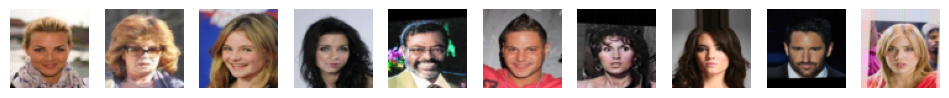

In [57]:
# Visualização das imagens
for images, labels in dataloader:
    break  # Pega o primeiro lote

# Desnormalizando as imagens
images = images * 0.5 + 0.5

# Configurando a plotagem
fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0))  # Permutando as dimensões para (H, W, C)
    
    ax.axis('off')

plt.show()

In [58]:
def Weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight.data)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.constant_(m.weight.data, 1.0)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [59]:
def dc_gen_block(in_dim, out_dim, kernel_size, stride, padding, out_batch):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding),
        nn.BatchNorm2d(out_dim, out_batch),
    )

In [60]:
class Generator(nn.Module):
    def __init__(self, init_dim):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.gen = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            dc_gen_block(128, 128, 3, 1, 1, 0.8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            dc_gen_block(128, 64, 3, 1, 1, 0.8),
            nn.ReLU(),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
            
        )

    def forward(self, x):
        out = self.l1(x)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.gen(out)
        return img
        

In [61]:
def dc_disc_block(in_dim, out_dim, kernel_size, stride, padding, out_batch):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding),
        nn.BatchNorm2d(out_dim, out_batch),
        nn.LeakyReLU(0.2, inplace=True),
    )

In [62]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(channels, 64, 3, 2, 1),  # Aqui 'channels' é 3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            dc_disc_block(64, 128, 3, 2, 1, 0.8),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        validity = self.disc(x)
        return validity

In [63]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [64]:
generator.apply(Weights_init_normal)
discriminator.apply(Weights_init_normal)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Dropout(p=0.25, inplace=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=32768, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [65]:
opt_g = torch.optim.Adam(generator.parameters(),lr=lr, betas=(b1, b2))
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

scheduler_G = torch.optim.lr_scheduler.StepLR(opt_g, step_size=50, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(opt_d, step_size=50, gamma=0.95)

In [66]:
def gen_loss(gen, disc, num_images, z_dim):
    noise = torch.randn(num_images,z_dim).to(device)
    real_label = torch.ones(num_images, 1).to(device)
    
    fake = gen(noise)
    pred_fake = disc(fake)
    criterion = nn.BCELoss()
    g_loss = criterion(pred_fake, real_label)
    return g_loss

In [67]:
def disc_loss(gen, disc, real, num_images, z_dim):
    noise = torch.randn(num_images,z_dim).to(device)
    fake_label = torch.zeros(num_images, 1).to(device)  # Mudando para 0
    real_label = torch.ones(num_images, 1).to(device)   # Mudando para 1

    criterion = nn.BCELoss()

    fake = gen(noise)
    pred_fake = disc(fake.detach())
    fake_loss = criterion(pred_fake, fake_label)
    
    pred_real = disc(real)
    real_loss = criterion(pred_real, real_label)

    total_loss = (fake_loss + real_loss) / 2
    return total_loss

Epoch 0/100, D Loss: 0.49740201234817505, G Loss: 0.889339029788971


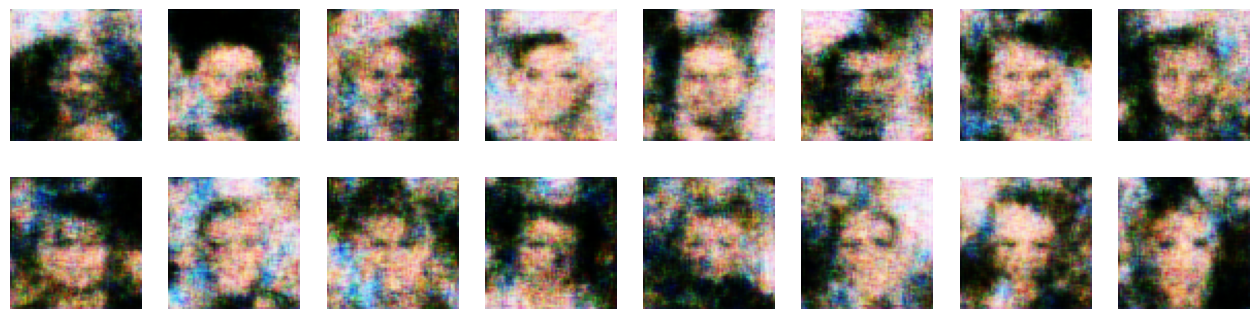

Epoch 10/100, D Loss: 0.7289053201675415, G Loss: 1.2937140464782715


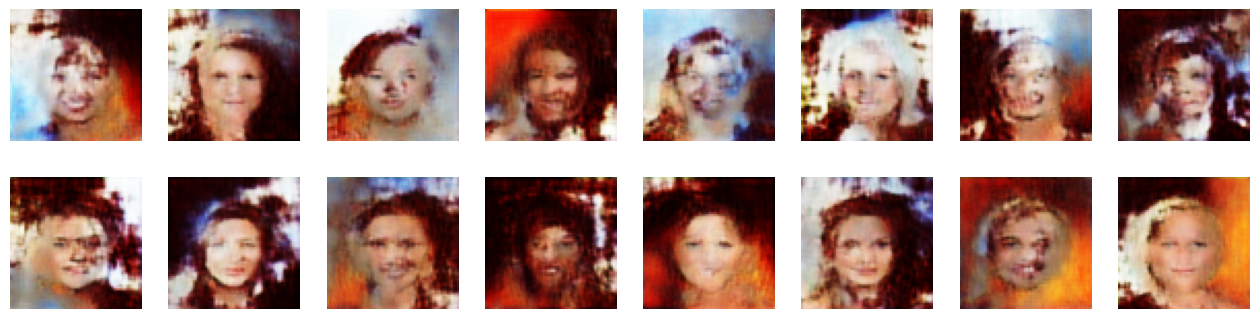

Epoch 20/100, D Loss: 0.579241156578064, G Loss: 0.8762298822402954


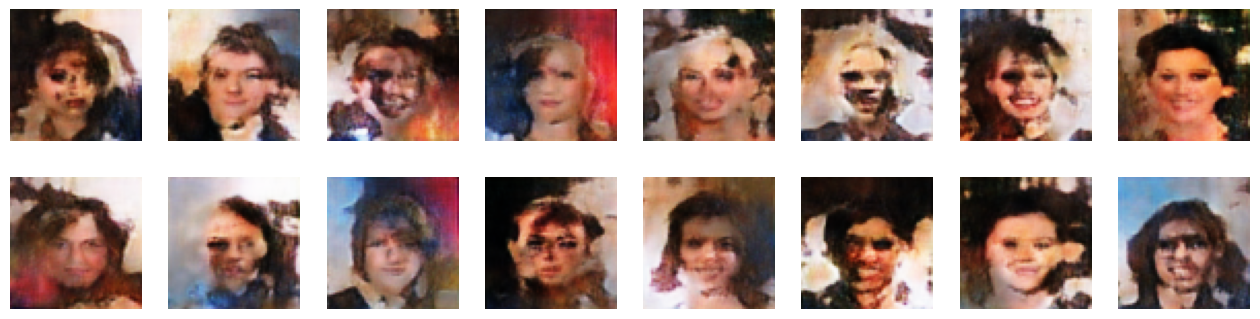

Epoch 30/100, D Loss: 0.6624926924705505, G Loss: 0.9187087416648865


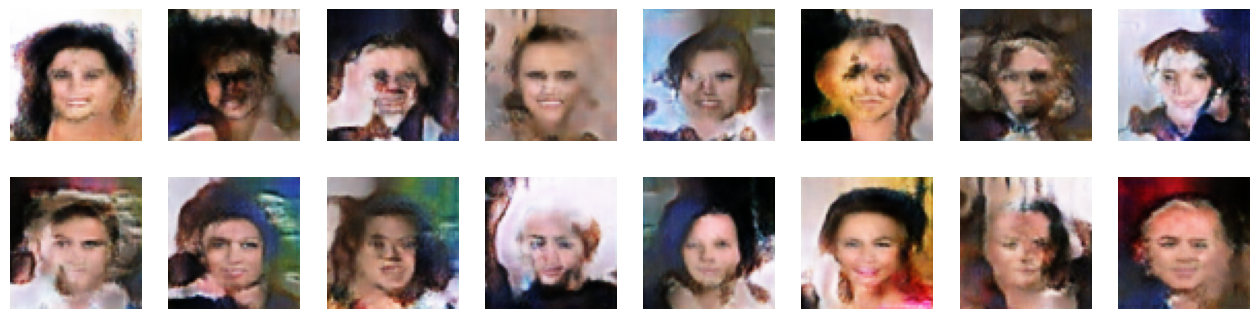

Epoch 40/100, D Loss: 0.68115234375, G Loss: 0.9602497816085815


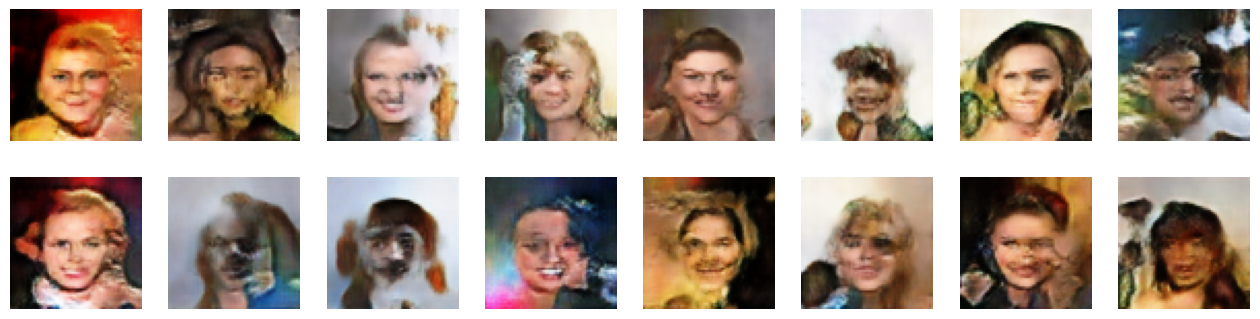

Epoch 50/100, D Loss: 0.6436980962753296, G Loss: 0.9063313007354736


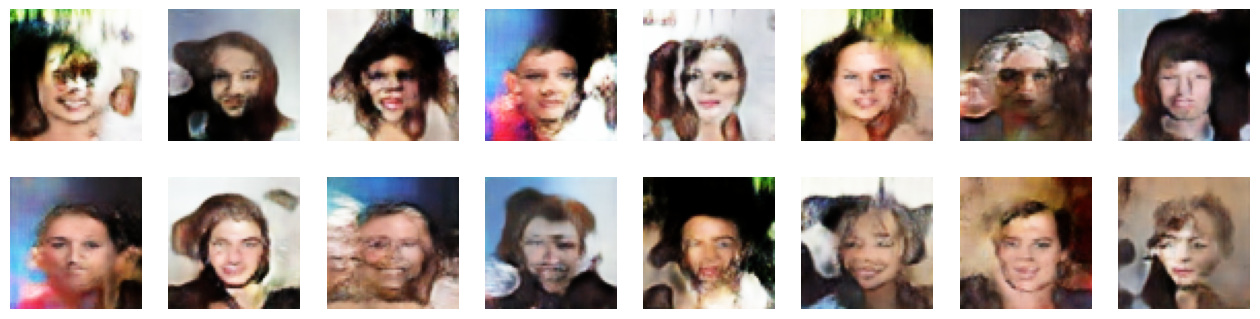

Epoch 60/100, D Loss: 0.6539473533630371, G Loss: 0.8413223028182983


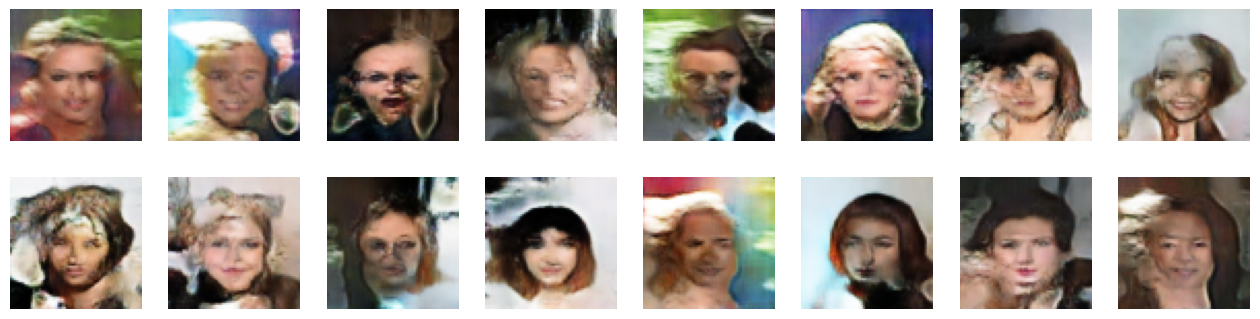

Epoch 70/100, D Loss: 0.6933912038803101, G Loss: 0.7599371671676636


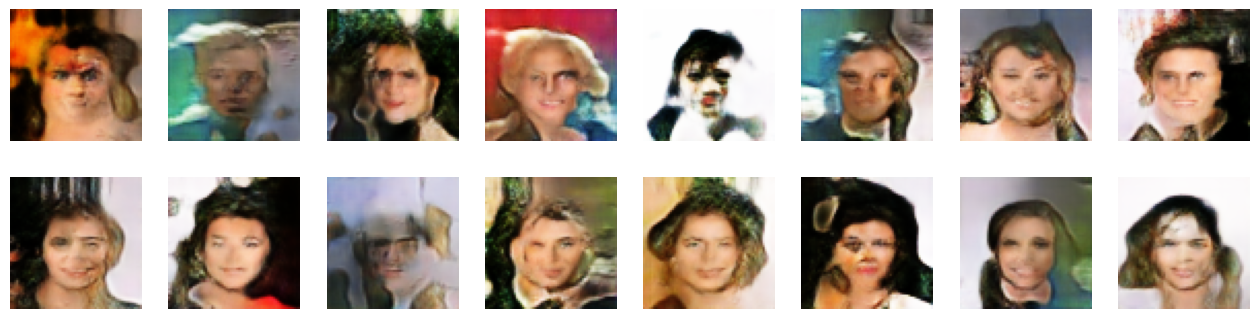

Epoch 80/100, D Loss: 0.6742513179779053, G Loss: 0.779784083366394


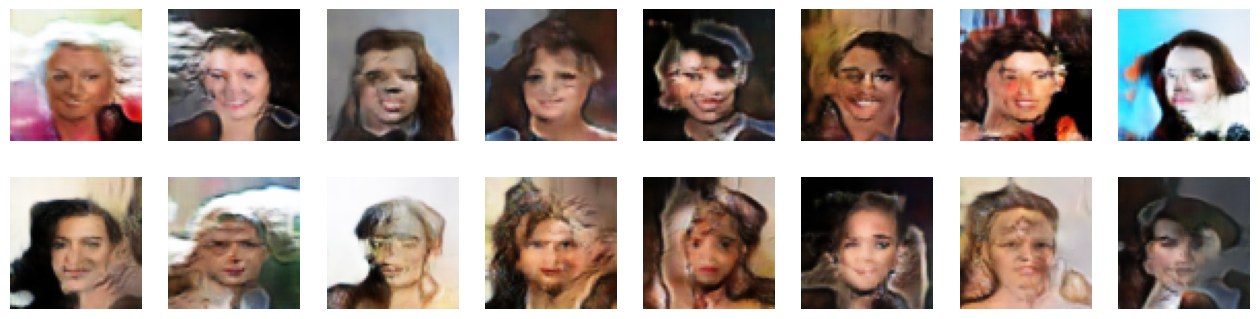

Epoch 90/100, D Loss: 0.668280839920044, G Loss: 1.0792689323425293


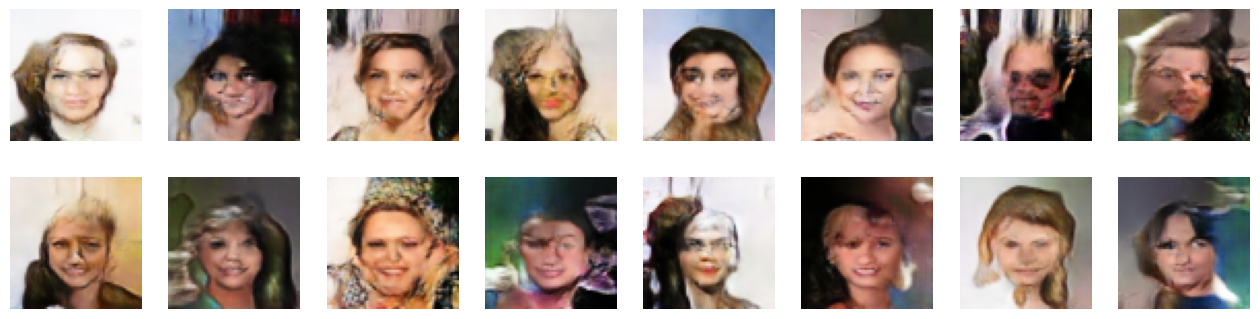

In [68]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        cur_batch_size = real_imgs.size(0)

        # Gerador
        opt_g.zero_grad()
        g_loss = gen_loss(generator, discriminator, cur_batch_size, latent_dim)
        g_loss.backward()
        opt_g.step()

        # Discriminador
        opt_d.zero_grad()
        d_loss = disc_loss(generator, discriminator, real_imgs, cur_batch_size, latent_dim)
        d_loss.backward()
        opt_d.step()

    # Exibindo as imagens somente quando a mensagem do print for chamada
    if epoch % 10 == 0:  # Aqui você escolhe o intervalo de épocas
        print(f"Epoch {epoch}/{n_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
        
        # Mostrar as imagens geradas
        generator.eval()
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            fake_imgs = generator(z)
            fake_imgs = fake_imgs * 0.5 + 0.5  # Desnormalizando
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            for idx, ax in enumerate(axes.flatten()):
                ax.imshow(fake_imgs[idx].permute(1, 2, 0).cpu().numpy())
                ax.axis('off')
            plt.show()
        generator.train()

    # Salvando os modelos a cada intervalo de amostra
    if epoch % sample_interval == 0:
        torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")
